# Fig. 5 panel E Sankey plot

In [7]:
import os, sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pysankey import sankey
import numpy as np

plt.rcParams['pdf.fonttype'] = 42

script_path = Path.cwd().parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent / "data"
sys.path.append(str(script_path))

from utils import *

output_folder = Path.cwd() / "output"
os.makedirs(output_folder, exist_ok=True)

## Load data

In [8]:
%store -r fig5_timestamp
print(f"Timestamp: {fig5_timestamp}")

# load the number of seeds used in the alignedUMAP
try:
    %store -r n_seeds
except:
    print("n_seeds not found. please specify (below) the number of bootstrap seeds (same as that used in Fig5_A_aligned_umap.ipynb)")
    n_seeds = 200

Timestamp: 2023-10-21-for-figures


In [9]:
# load adata
csv_path = Path.cwd().parent / "panel_C" / "output" / f"{fig5_timestamp}_umap_table.csv"

try:
    # load the file
    umap_table = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"File {csv_path} not found.\nPlease run leiden analysis first (fig5 panel C) or specify the correct timestamp, current value is {fig5_timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# check the shape of the data
u_df = umap_table.copy()
u_df.shape

### subset data



In [12]:
# The goal of this figure is to specifically visualize how infection hits distribute between compartments. 
# Therefore, we do not plot "diagonal" proteins in the Sankey diagram if they are not infection hits.

# hits boolean
hit_threshold = 1.6738 # as calculated in Fig5_B_remodeling_score.ipynb
hits_bool = (u_df[f"10d_mean_distance_traveled ({n_seeds} bootstraps)"] > hit_threshold).to_list()
print(f"number of hits: {sum(hits_bool)}")

# diagonal boolean
diagonal_bool = u_df["cluster_annot_uninf"] != u_df["cluster_annot_inf"]
print(f"number of diagonals: {sum(diagonal_bool)}")

# remove diagonals that are not hits (see the comment at the top of this cell)
u_df = u_df[(~diagonal_bool) | (hits_bool)]

number of hits: 644
number of diagonals: 1638


In [13]:
u_df.shape

(6907, 75)

### Sankey plot

In [14]:
# specify the colors of the clusters
colorDict = {
    "nucleus": "#DB5F57",
    "cytosol": "#A2CE5A",
    "mitochondrion": "#59B6DC",
    "ER": "#DB9C58",
    "plasma memb. & actin": "#B96EAD",
    "endo-lysosome & trans-Golgi": "#DBD956",
    "ERGIC/Golgi": "#6BC7BB",
    "translation/RNA granules": "#414042",
    "signaling scaffold": "yellow",
    "peroxisome": "#EC008C",
    "COPI vesicle": "red",
    "centrosome": "#955FA7",
    "unlabelled": "grey",
}

In [16]:
# check sankey left side labels
u_df["cluster_annot_uninf"].unique()

array(['nucleus', 'cytosol', 'endo-lysosome & trans-Golgi',
       'translation/RNA granules', 'plasma memb. & actin', 'ER',
       'mitochondrion', 'peroxisome', 'ERGIC/Golgi', 'centrosome'],
      dtype=object)

In [17]:
# check sankey right side labels
u_df["cluster_annot_inf"].unique()

array(['nucleus', 'cytosol', 'endo-lysosome & trans-Golgi',
       'translation/RNA granules', 'plasma memb. & actin', 'ER',
       'mitochondrion', 'peroxisome', 'unlabelled', 'centrosome',
       'COPI vesicle'], dtype=object)

In [18]:
# remove unlabeled
u_df = u_df[u_df["cluster_annot_inf"] != "unlabelled"]

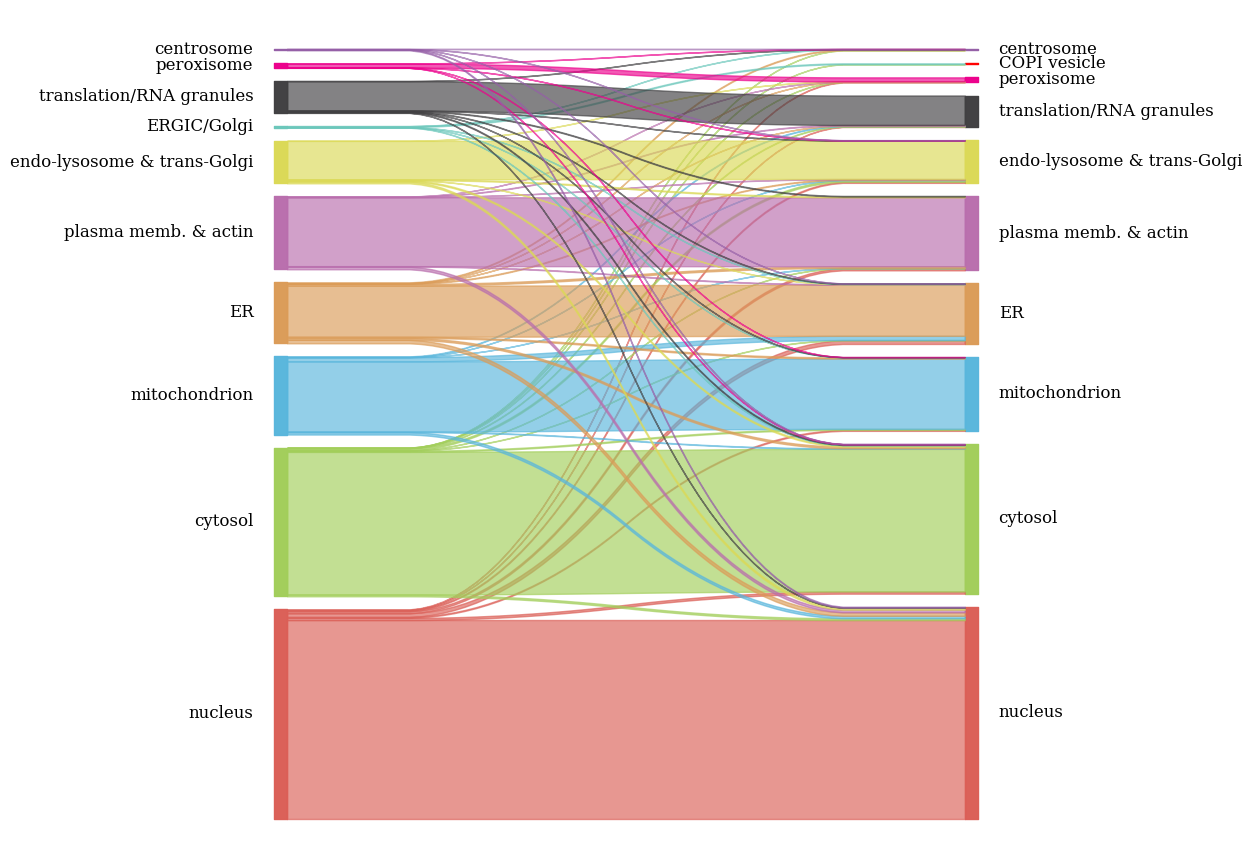

In [19]:
plt.figure(figsize=(10, 11))
ax = sankey(
    u_df["cluster_annot_uninf"],
    u_df["cluster_annot_inf"],
    aspect=20,
    colorDict=colorDict, fontsize=12, color_gradient=False,
    leftLabels=[ # define the order of the left labels
        "nucleus",
        "cytosol",
        "mitochondrion",
        "ER",
        "plasma memb. & actin",
        "endo-lysosome & trans-Golgi",
        "ERGIC/Golgi",
        "translation/RNA granules",
        "peroxisome",
        "centrosome"
    ],
    rightLabels=[ # define the order of the right labels
        "nucleus",
        "cytosol",
        "mitochondrion",
        "ER",
        "plasma memb. & actin",
        "endo-lysosome & trans-Golgi",
        "translation/RNA granules",
        "peroxisome",
        "COPI vesicle",
        "centrosome"
    ],
)

# save figure
plt.savefig(output_folder / "sankey_plot.pdf", format="pdf", dpi=300)